# 第5章 大規模言語モデルのファインチューニング

# 第5章 大規模言語モデルのファインチューニング

**注意**
2023/7/28現在、MARC-jaのデータセットの配布元のリンクが切れており、書籍上の5.2、5.3、5.5.4節に掲載されているコードにおいて、データセット読み込みの箇所でエラーが出る状態です。こちらのノートブックは、MARC-jaと同様の感情分析のデータセットであるWRIMEを用いて書籍と同様のコードを実行するために用意されています。

## 5.3 感情分析モデルのエラー分析

In [ ]:
!pip install datasets transformers[ja,torch] matplotlib scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.4/492.4 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.9/599.9 kB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 96.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) .

### 5.3.1 モデルの予測結果の取得

In [ ]:
from transformers import pipeline

model_name = "llm-book/bert-base-japanese-v3-wrime-sentiment"
sentiment_pipeline = pipeline(model=model_name, device="cuda:0")

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [ ]:
from datasets import load_dataset

valid_dataset = load_dataset("llm-book/wrime-sentiment", split="validation")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
from tqdm import tqdm

# ラベル名の情報を取得するためのClassLabelインスタンス
class_label = valid_dataset.features["label"]

results: list[dict[str, float | str]] = []
for i, example in tqdm(enumerate(valid_dataset)):
    # モデルの予測結果を取得
    model_prediction = sentiment_pipeline(example["sentence"])[0]
    # 正解のラベルIDをラベル名に変換
    true_label = class_label.int2str(example["label"])

    # resultsに分析に必要な情報を格納
    results.append(
        {
            "example_id": i,
            "pred_prob": model_prediction["score"],
            "pred_label": model_prediction["label"],
            "true_label": true_label,
        }
    )

10it [00:03,  4.06it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
1608it [00:22, 72.95it/s]


### 5.3.2 全体的な傾向の分析

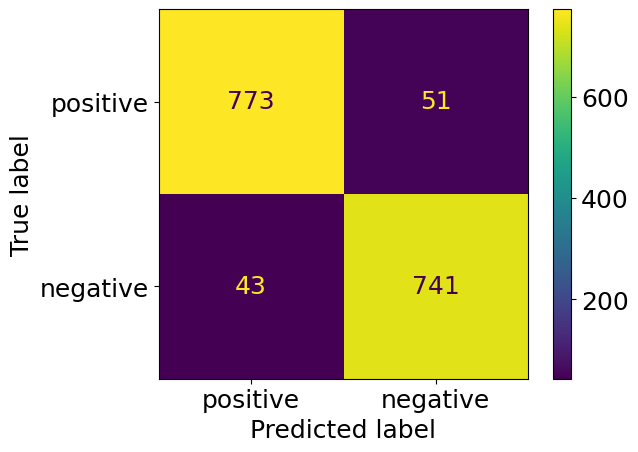

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

plt.rcParams["font.size"] = 18  # 文字サイズを大きくする

# 混同行列の作成
confusion_matrix = confusion_matrix(
    y_true=[result["true_label"] for result in results],
    y_pred=[result["pred_label"] for result in results],
    labels=class_label.names,
)
# 混同行列を画像として表示
ConfusionMatrixDisplay(
    confusion_matrix, display_labels=class_label.names
).plot()

### 5.3.3 モデルのショートカットに注意

In [ ]:
# 予測が誤った事例を収集
failed_results = [
    res for res in results if res["pred_label"] != res["true_label"]
]
# モデルの予測確率が高い順にソート
sorted_failed_results = sorted(
    failed_results, key=lambda x: -x["pred_prob"]
)
# 高い確率で予測しながら誤った事例の上位2件を表示
for top_result in sorted_failed_results[:5]:
    review_text = valid_dataset[top_result["example_id"]]["sentence"]
    print(f"レビュー文：{review_text}")
    print(f"予測：{top_result['pred_label']}")
    print(f"正解：{top_result['true_label']}")
    print(f"予測確率: {top_result['pred_prob']:.4f}")
    print("----------------")

レビュー文：何のこれしき会社員だった頃の辛さに比べれば。まあ種類が違うけど。


予測：negative
正解：positive
予測確率: 0.9993
----------------
レビュー文：今年のプリキュアの決め台詞が、
 
「お大事に」

今年にマッチングし過ぎてて、プリキュアスタッフの先見の明がすご過ぎるし、何が言いたいかと言うと変身する棒を買わされました。
予測：positive
正解：negative
予測確率: 0.9993
----------------
レビュー文：ツイッター早朝部、いくわよ！！ あと諸事情により数人ブロックさせて頂きました…申し訳ない……
予測：negative
正解：positive
予測確率: 0.9992
----------------
レビュー文：酒はぬるめの 燗がいい 肴は炙った イカでいい←もっといいもの食えよ
予測：positive
正解：negative
予測確率: 0.9992
----------------
レビュー文：できれば今すぐお線香あげにいきたい
予測：positive
正解：negative
予測確率: 0.9992
----------------


**注意**
2023/7/28現在、MARC-jaのデータセットの配布元のリンクが切れており、書籍上の5.2、5.3、5.5.4節に掲載されているコードにおいて、データセット読み込みの箇所でエラーが出る状態です。このため、MARC-jaと同様の感情分析のデータセットであるWRIMEを用いた同様のノートブックを[こちら](https://colab.research.google.com/github/ghmagazine/llm-book/blob/main/chapter5/5-3-sentiment-analysis-analysis-wrime.ipynb)に用意しましたので適宜ご参照ください。

## 5.3 感情分析モデルのエラー分析

In [ ]:
!pip install datasets transformers[ja,torch] matplotlib scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 85.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.9/599.9 kB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 105.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 12.3 MB/s eta 

### 5.3.1 モデルの予測結果の取得

In [ ]:
from transformers import pipeline

model_name = "llm-book/bert-base-japanese-v3-marc_ja"
marc_ja_pipeline = pipeline(model=model_name, device="cuda:0")

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [ ]:
from datasets import load_dataset

valid_dataset = load_dataset(
    "llm-book/JGLUE", name="MARC-ja", split="validation"
)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

/root/.cache/huggingface/modules/datasets_modules/datasets/llm-book--JGLUE/afed02e914319785e72f3ea981b4bd3e00089f2361b1137820c183c6b8173edd/preprocess_marc_ja.py:193: UserWarning: can't import `mojimoji`, failing back to method that do nothing. We recommend running `pip install mojimoji` to reproduce the original preprocessing.
  warnings.warn(
Remove html tags from the text:   0%|          | 0/234228 [00:00<?, ?it/s]/root/.cache/huggingface/modules/datasets_modules/datasets/llm-book--JGLUE/afed02e914319785e72f3ea981b4bd3e00089f2361b1137820c183c6b8173edd/preprocess_marc_ja.py:206: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, "html.parser").get_text()
Remove html tags from the text:  13%|█▎        | 29673/234228 [00:06<00:35, 5798.70it/s]/root/.cache/huggingface/modules/datasets_modules/datasets/llm-book--JGLUE/afed02e914319785e72f3ea981b4bd3e00089

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset jglue downloaded and prepared to /root/.cache/huggingface/datasets/llm-book___jglue/MARC-ja/1.1.0/afed02e914319785e72f3ea981b4bd3e00089f2361b1137820c183c6b8173edd. Subsequent calls will reuse this data.


In [ ]:
from tqdm import tqdm

# ラベル名の情報を取得するためのClassLabelインスタンス
class_label = valid_dataset.features["label"]

results: list[dict[str, float | str]] = []
for i, example in tqdm(enumerate(valid_dataset)):
    # モデルの予測結果を取得
    model_prediction = marc_ja_pipeline(example["sentence"])[0]
    # 正解のラベルIDをラベル名に変換
    true_label = class_label.int2str(example["label"])

    # resultsに分析に必要な情報を格納
    results.append(
        {
            "example_id": i,
            "pred_prob": model_prediction["score"],
            "pred_label": model_prediction["label"],
            "true_label": true_label,
        }
    )

9it [00:00, 18.97it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
5654it [01:28, 64.12it/s]


### 5.3.2 全体的な傾向の分析

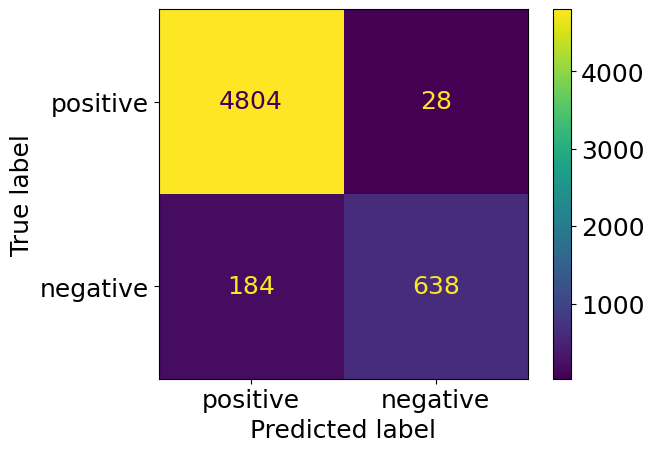

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

plt.rcParams["font.size"] = 18  # 文字サイズを大きくする

# 混同行列の作成
confusion_matrix = confusion_matrix(
    y_true=[result["true_label"] for result in results],
    y_pred=[result["pred_label"] for result in results],
    labels=class_label.names,
)
# 混同行列を画像として表示
ConfusionMatrixDisplay(
    confusion_matrix, display_labels=class_label.names
).plot()

### 5.3.3 モデルのショートカットに注意

In [ ]:
# 予測が誤った事例を収集
failed_results = [
    res for res in results if res["pred_label"] != res["true_label"]
]
# モデルの予測確率が高い順にソート
sorted_failed_results = sorted(
    failed_results, key=lambda x: -x["pred_prob"]
)
# 高い確率で予測しながら誤った事例の上位2件を表示
for top_result in sorted_failed_results[:2]:
    review_text = valid_dataset[top_result["example_id"]]["sentence"]
    print(f"レビュー文：{review_text}")
    print(f"予測：{top_result['pred_label']}")
    print(f"正解：{top_result['true_label']}")
    print(f"予測確率: {top_result['pred_prob']:.4f}")
    print("----------------")

レビュー文：OP/TECHのストラップを使用している方でしたら、この商品をはじめとしたコネクターを追加することで使い勝手を向上させることができます。私の場合は[[ASIN:B003GTUYWQ KATA カメラリュック Pro-lightコレクション 28.8L PCスペース有 三脚装着可能 レインカバー付属 ブラック KT PL-B-220]]に取り付けて使用しています。普段はOP/TECHのユーティリティストラップを使用していますが、重量級のレンズを装着したカメラを長時間首に負荷のかかる状態は少々つらく、このシステムコネクターを使ってリュックとカメラをつなぐことで重量を分散することができます。商品の性能には満足していますが、多少割高感があるため星ひとつ減点。
予測：positive
正解：negative
予測確率: 0.9996
----------------
レビュー文：まず，紙ジャケット仕様とありますが，正確には紙ケースです．そのケースはちょうどCD２枚組用のハードケースがぴったり入りそうな紙ケースなのですが，その中にケースより一回り小さな写真集と歌詞カードが入っています．中がすかすかなんですが，私だけでしょうか？これで3780円ですか？？？他のシリーズが出来が良いだけに，なんか残念で☆4つにさせて頂きました．
予測：positive
正解：negative
予測確率: 0.9996
----------------


In [ ]:
text = "まず，紙ジャケット仕様とありますが，正確には紙ケースです．そのケースはちょうどCD２枚組用のハードケースがぴったり入りそうな紙ケースなのですが，その中にケースより一回り小さな写真集と歌詞カードが入っています．中がすかすかなんですが，私だけでしょうか？これで3780円ですか？？？他のシリーズが出来が良いだけに，なんか残念で☆４つにさせて頂きました"

In [ ]:
print(marc_ja_pipeline(text)[0])

{'label': 'positive', 'score': 0.9995942711830139}


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
print(marc_ja_pipeline(text.replace("☆４つ", ""))[0])

{'label': 'negative', 'score': 0.9759078025817871}


In [ ]:
print(marc_ja_pipeline("絶対に買わないで。最悪です。")[0])

{'label': 'negative', 'score': 0.9948933124542236}


In [ ]:
print(marc_ja_pipeline("絶対に買わないで。最悪です。星４つ。")[0])

{'label': 'positive', 'score': 0.9945051074028015}
